#### Jericho McLeod <br>Assignment 3<br>CSI-777

### Ex3: 
#### Using the glass dataset, run a k-nearest-neighbors classifier for k=1..5 and evaluate each with a 10 fold cross-validation. Discuss the accuracy of each.

First, I will import and examine the data to get some level of familiarity with it.

In [1]:
import pandas as pd
import numpy as np
import random, copy
import matplotlib.pyplot as plt
glass = pd.read_csv("glass.csv") 
glass.head()

,refractive_index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,Type
0,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.0,0.00,'build wind float'
1,1.51643,12.16,3.52,1.35,72.89,0.57,8.53,0.0,0.00,'vehic wind float'
2,1.51793,13.21,3.48,1.41,72.64,0.59,8.43,0.0,0.00,'build wind float'
3,1.51299,14.40,1.74,1.54,74.55,0.00,7.59,0.0,0.00,tableware
4,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.0,0.24,'build wind non-float'


#### Transformation 

The differences between values within attributes varies widely; this means that some attributes will matter more for distance comparisons than others. To account for this, we are going to normalize the data. 

I elected to use a min-max normalization because the data did not appear to be consistently normally distributed; in a bimodal dataset

Additionally, we need to create subsets of the data for 10-fold cross validation. We will achieve this by adding a new column of random numbers from 1 to 10, then creating 10 train/test sets where each set has a different selection withheld for testing.

In [2]:
cols = glass.columns
cols_to_norm = cols[0:-2]
for i in cols_to_norm:
    glass[i]=(glass[i]-glass[i].min())/(glass[i].max()-glass[i].min())


glass['10fold'] = np.random.randint(1, 11, glass.shape[0])
glass.head()

,refractive_index,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron,Type,10fold
0,0.297629,0.309774,0.779510,0.258567,0.575000,0.103060,0.310409,0.0,0.00,'build wind float',1
1,0.231782,0.215038,0.783964,0.330218,0.550000,0.091787,0.288104,0.0,0.00,'vehic wind float',9
2,0.297629,0.372932,0.775056,0.348910,0.505357,0.095008,0.278810,0.0,0.00,'build wind float',8
3,0.080773,0.551880,0.387528,0.389408,0.846429,0.000000,0.200743,0.0,0.00,tableware,8
4,1.000000,0.236090,0.000000,0.221184,0.062500,0.019324,1.000000,0.0,0.24,'build wind non-float',8


#### Data management
Now we will create the datastructure to store the references to each component of the original dataset for the test and train components. 

In [3]:
glass_dict = {}
for i in range(10):
    fold = i+1
    glass_test = glass[glass['10fold'] == fold]
    glass_train = glass[glass['10fold'] != fold]
    del glass_train['10fold']
    del glass_test['10fold']
    glass_dict[fold] = {'test':glass_test,'train':glass_train}

for k,v in glass_dict.items():
    for k2,v2 in v.items():
        print("%5s %2d   Length: %3d"%(k2,k,len(v2)))
#        print(v2)
#        print()

 test  1   Length:  23
train  1   Length: 191
 test  2   Length:  22
train  2   Length: 192
 test  3   Length:  18
train  3   Length: 196
 test  4   Length:  19
train  4   Length: 195
 test  5   Length:  24
train  5   Length: 190
 test  6   Length:  21
train  6   Length: 193
 test  7   Length:  24
train  7   Length: 190
 test  8   Length:  23
train  8   Length: 191
 test  9   Length:  12
train  9   Length: 202
 test 10   Length:  28
train 10   Length: 186


#### Functions
We will need to find distances between the instances we are testing and the instances we are using to classify the test data. The below function returns the euclidean distances of two arrays using:<br><br>
$$\sqrt{\sum_{i=1}^{n} (x_i-y_i)^2}$$

In [4]:
def calc_euclidean(array1,array2):
    if len(array1)==len(array2):
        ss = 0
        for i in range(len(array1)):
            ss += (array1[i]-array2[i])**2
        dist = ss**0.5
        return(dist)
    else:
        print("ERROR: distance cannot be calculated between arrays of different lengths")

The results of the k-nearest neighbors are textual, and we need to return the most commonly returned results, or the mode, of this textual array. The function below counts the results in the array and returns the maximum count. If two values are equally represented and appear more than once in the input array, the likelihood of either being returned if 0.5. 

This means that if all five values are different, the nearest will be returned as the mode, because the array is built from smallest distance to largest. 

In cases where there are two instances of each of two different values, the value returned will be randomly selected from these. Since we are limited to k=5, values greater than 2 do not need to be considered.

In [5]:
def get_mode(array):
    test_dict = {}
    for i in array:
        if i not in test_dict:
            test_dict[i]=1
        else:
            test_dict[i]+=1
    max_val = 0
    mode = ''
    for k,v in test_dict.items():
        if v>max_val:
            mode = k
        elif v==max_val and v>1:
            if random.random() > 0.5:
                mode = k
    return(mode)

We will also need to calculate means of numerical arrays. This is done using the common $\frac{\sum_{i=1}^{n}x_i}{n}$ formula.

In [6]:
def array_mean(array):
    total =0
    for i in array:
        total+=i
    mean = total/len(array)
    return(mean)

#### KNN Algorithm
The actual KNN algorithm is represented below. <br>
1. Iterate through each instance in the testing dataset, extracting the numerical data and the existing result.
2. Iterate through the testing data, finding the k nearest neighbors to the current test instance using Euclidean distance. 
3. Add the target variable for the training instances to an array and finds the mode of that array. 
4. Compare the mode to the observed test value and collect the results
5. Using the collected results, determine the correct classification rate and return this value

In [7]:
def knn(df_train,df_test,k):
    correct = []
    for index,row in df_test.iterrows():
        distance_dict,distance_vect,test_vec = {},[],[]
        true_out = row[-1]
        for i in row[:-1]:
            test_vec.append(i)
        for tr_index,tr_row in df_train.iterrows():
            train_vec = []
            train_out = tr_row[-1]
            for i in tr_row[:-1]:
                train_vec.append(i)
            dist = calc_euclidean(test_vec,train_vec)
            distance_dict[dist]=train_out
            distance_vect.append(dist)
        distance_vect = sorted(distance_vect)
        neighbor_outcomes = []
        for i in distance_vect[0:k+1]:
            neighbor_outcomes.append(distance_dict[i])
        mode = get_mode(neighbor_outcomes)
        if mode == true_out:
            correct.append(1)
        else:
            correct.append(0)
    rate = array_mean(correct)
    return(rate)

#### Running the algorithm

A loop was created to compare the KNN algorithm across neighbor counts ranging from 1 to 5. It prints the results to the terminal with explanatory text.

In [8]:
initial_results = []
for i in range(1,6):
    rates = []
    for j in range(1,11):
        rate = knn(glass_dict[j]['train'],glass_dict[j]['test'],i)
        rates.append(rate)
    mean = array_mean(rates)
    initial_results.append(mean)
    print("For %2d nearest neighbors, the accuracy is %4f"%(i,mean))


For  1 nearest neighbors, the accuracy is 0.630813
For  2 nearest neighbors, the accuracy is 0.583720
For  3 nearest neighbors, the accuracy is 0.535222
For  4 nearest neighbors, the accuracy is 0.497297
For  5 nearest neighbors, the accuracy is 0.454741


#### Examining results 
That is pretty low accuracy, so we need to further examine the data to see if maybe we can determine why. Based on some prior in class discussion, this can be done in a parallel coordinates graph. 

0 'build wind float'
1 'vehic wind float'
2 tableware
3 'build wind non-float'
4 headlamps
5 containers


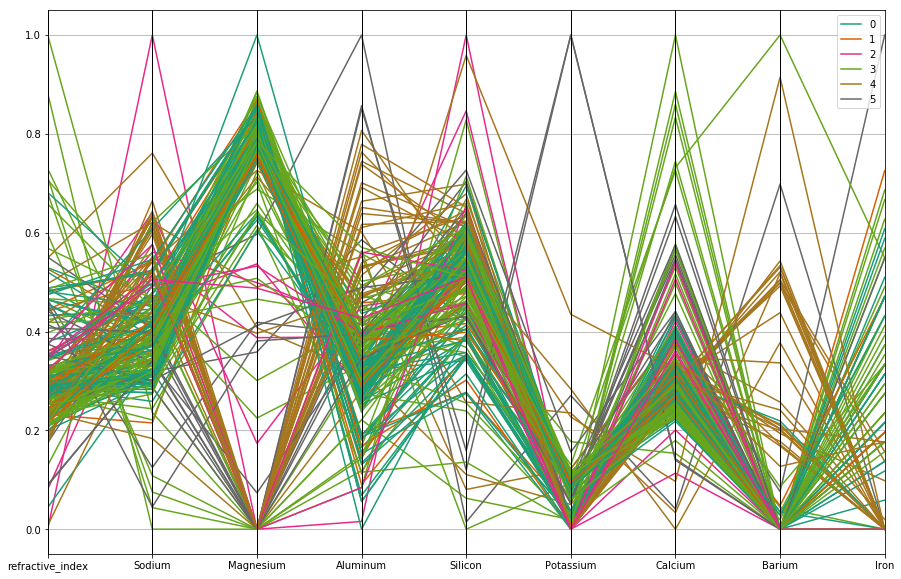

In [9]:
glass2 = copy.deepcopy(glass)
cols = glass2.columns
cols_to_norm = cols[0:-2]
for i in cols_to_norm:
    glass2[i]=(glass2[i]-glass2[i].min())/(glass2[i].max()-glass2[i].min())


cols = glass2.columns
#print(cols)
types = []
new_type = []
for i in glass2['Type']:
    if i not in types:
        types.append(i)
    index = types.index(i)
    new_type.append(index)
glass2['Type2']=new_type
for i in range(len(types)):
    print("%d %s"%(i,types[i]))
    
glass2.head()
glass2.drop('Type', axis=1, inplace=True) 
glass2.drop('10fold', axis=1, inplace=True) 

plt.figure(figsize=(15,10))
fig = pd.plotting.parallel_coordinates(glass2, 'Type2', colormap=plt.get_cmap("Dark2"))
plt.show()



That is relatively messy, so let's also look at the means.

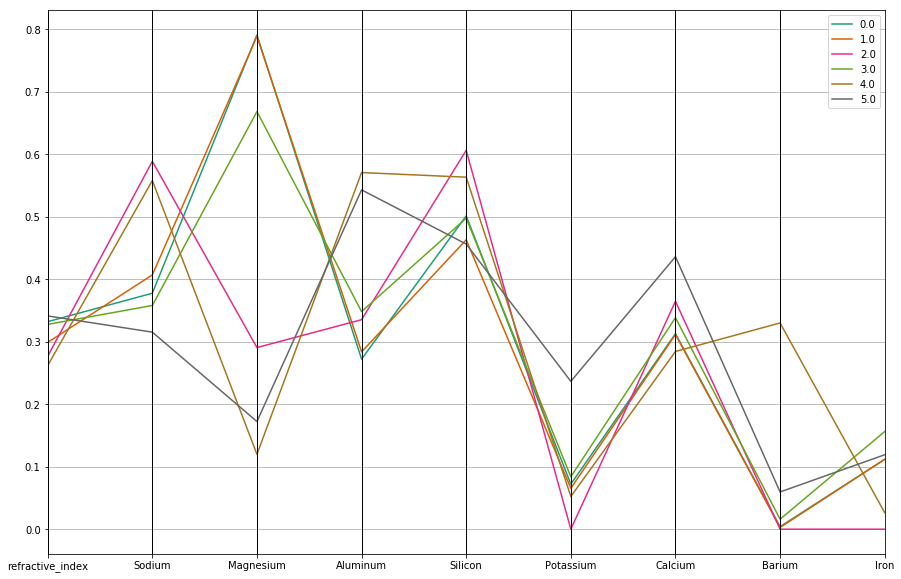

In [10]:

build_wind_float = glass2[glass2['Type2']==0]
vehic_wind_float = glass2[glass2['Type2']==1]
tableware = glass2[glass2['Type2']==2]
build_wind_non_float = glass2[glass2['Type2']==3]
headlamps = glass2[glass2['Type2']==4]
containers = glass2[glass2['Type2']==5]

cols = ['refractive_index', 'Sodium', 'Magnesium', \
        'Aluminum', 'Silicon', 'Potassium', 'Calcium', 'Barium', 'Iron', 'Type2']
classes = [build_wind_float,vehic_wind_float,\
           tableware,build_wind_non_float,headlamps,containers]

top_array = []
for i in classes:
    array = []
    for j in cols:
        array.append(i[j].mean())
    top_array.append(array)
glass_average = pd.DataFrame(top_array)

glass_average.columns = cols
glass_average.head()

plt.figure(figsize=(15,10))
fig = pd.plotting.parallel_coordinates(glass_average, 'Type2', colormap=plt.get_cmap("Dark2"))

plt.show()

#### Interpret additional exploration

It looks as though part of our problem is the min-max seems to have crunched our data together. Let's try the same thing, but this time using a z-transformation, and look at the graph prior to running KNN.

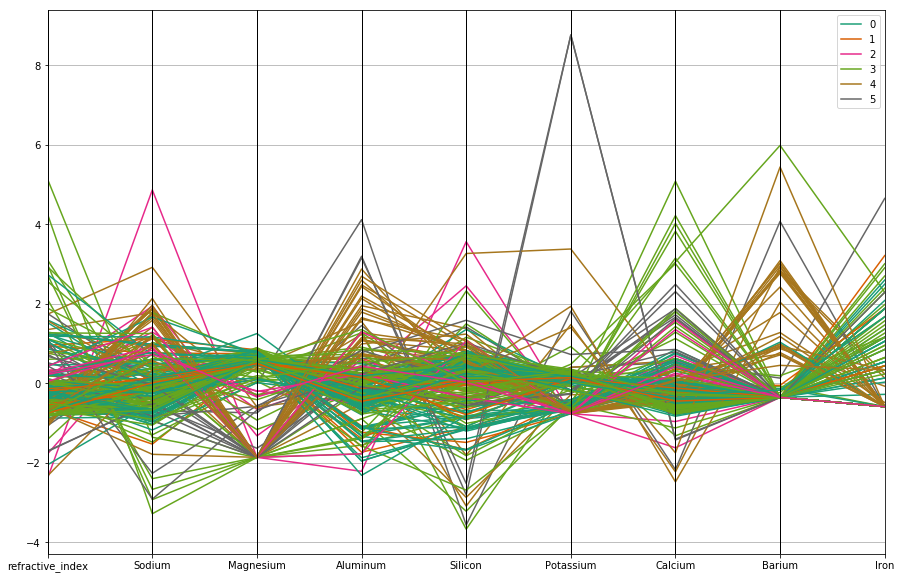

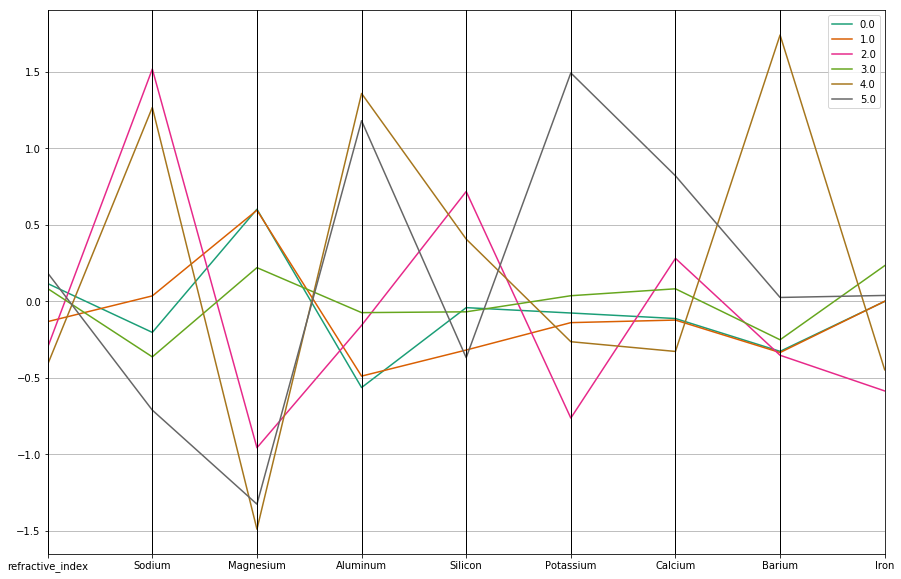

In [11]:
glass2 = copy.deepcopy(glass)
cols = glass2.columns
cols_to_norm = cols[0:-2]
for i in cols_to_norm:
    glass2[i]=(glass2[i]-glass2[i].mean())/glass2[i].std()


cols = glass2.columns
types = []
new_type = []
for i in glass2['Type']:
    if i not in types:
        types.append(i)
    index = types.index(i)
    new_type.append(index)
glass2['Type2']=new_type
 
glass2.head()
glass2.drop('Type', axis=1, inplace=True) 
glass2.drop('10fold', axis=1, inplace=True) 
plt.figure(figsize=(15,10))
fig = pd.plotting.parallel_coordinates(glass2, 'Type2', colormap=plt.get_cmap("Dark2"))
#glass2.plot(figsize=(10,10))
#plt.plot(figsize=(10,5))
plt.show()
build_wind_float = glass2[glass2['Type2']==0]
vehic_wind_float = glass2[glass2['Type2']==1]
tableware = glass2[glass2['Type2']==2]
build_wind_non_float = glass2[glass2['Type2']==3]
headlamps = glass2[glass2['Type2']==4]
containers = glass2[glass2['Type2']==5]

cols = ['refractive_index', 'Sodium', 'Magnesium', \
        'Aluminum', 'Silicon', 'Potassium', 'Calcium', 'Barium', 'Iron', 'Type2']
classes = [build_wind_float,vehic_wind_float,\
           tableware,build_wind_non_float,headlamps,containers]

top_array = []
for i in classes:
    array = []
    for j in cols:
        array.append(i[j].mean())
    top_array.append(array)
glass_average = pd.DataFrame(top_array)

glass_average.columns = cols
glass_average.head()

plt.figure(figsize=(15,10))
fig = pd.plotting.parallel_coordinates(glass_average, 'Type2', colormap=plt.get_cmap("Dark2"))

plt.show()


#### Interpret new transformation visualization

This is notably less 'clumpy' across classifications, which is what we were hoping to see. Now we need to test whetheer it has an impact on the classifier.

In [12]:
glass = pd.read_csv("glass.csv") 
glass.head()
cols = glass.columns
cols_to_norm = cols[0:-2]
for i in cols_to_norm:
    glass[i]=(glass[i]-glass[i].mean())/glass[i].std()


glass['10fold'] = np.random.randint(1, 11, glass.shape[0])
glass.head()
glass_dict = {}
for i in range(10):
    fold = i+1
    glass_test = glass[glass['10fold'] == fold]
    glass_train = glass[glass['10fold'] != fold]
    del glass_train['10fold']
    del glass_test['10fold']
    glass_dict[fold] = {'test':glass_test,'train':glass_train}

final_results = []
for i in range(1,6):
    rates = []
    for j in range(1,11):
        rate = knn(glass_dict[j]['train'],glass_dict[j]['test'],i)
        rates.append(rate)
    mean = array_mean(rates)
    final_results.append(mean)
    print("For %2d nearest neighbors, the accuracy is %4f"%(i,mean))

For  1 nearest neighbors, the accuracy is 0.702948
For  2 nearest neighbors, the accuracy is 0.636951
For  3 nearest neighbors, the accuracy is 0.524317
For  4 nearest neighbors, the accuracy is 0.489139
For  5 nearest neighbors, the accuracy is 0.443465


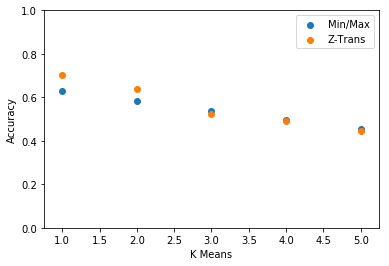

In [13]:
y = []
for i in range(1,6):
    y.append(i)
    
plt.scatter(y,initial_results,label='Min/Max')
plt.scatter(y,final_results,label='Z-Trans')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.xlabel('K Means')
plt.legend()
plt.show()

#### Final results discussion

In both the z-transformation and min-max transformation we see a decrease in accuracy as K increases. This could be because of the mixture of the data across classes. It is interesting that a z-transformation helped to distinguish classes a bit, but as more neighbors are added this diminished to be roughly the same as the min-max KNN classifier.

I think that my rough impression initially is that two instances may have a high euclidean distance in some variables, but low in others, and that the classification is being weakened by the dimensionality of the data. If I were to continue examining this model I would want to look at subsetting variables and building a voting system that only checked euclidean distances within pairs of variables. Then, by looking at which of those have better accuracy, if any, I could build a model that looked for the properties that cause any increased accuracy within variables before building the classifier. 